In [1]:
# !apt-get install -y libspatialindex-c4v5
# !pip3.6 install osmnx

import osmnx as ox
import networkx as nx
import pandas as pd
import json
import requests

from rtree import index
from shapely.geometry import box
from utils import *

In [2]:
place_name = "Singapore, Central, Singapore"
G = ox.save_load.load_graphml(filename="Singapore_drive_processed.graphml")
G_whole = ox.save_load.load_graphml(filename="Singapore_processed.graphml")

# Stores nodes and edges mapped with speed bands along with other attributes
print(type(G))
print(type(G_whole))

<class 'networkx.classes.multidigraph.MultiDiGraph'>
<class 'networkx.classes.multidigraph.MultiDiGraph'>


In [3]:
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
nodes = pd.read_pickle('data/nodes_drive.pkl')

In [4]:
nodes.head()

,y,x,osmid,highway,geometry,ref
1820000257,1.356580,103.932616,1820000257,traffic_signals,POINT (103.93262 1.35658),NaN
3874553858,1.319182,103.921237,3874553858,NaN,POINT (103.92124 1.31918),NaN
1820000259,1.356647,103.932745,1820000259,traffic_signals,POINT (103.93275 1.35665),NaN
3874553857,1.319219,103.921661,3874553857,NaN,POINT (103.92166 1.31922),NaN
2083586053,1.400663,103.872050,2083586053,NaN,POINT (103.87205 1.40066),NaN


In [7]:
f = open("../../Traffic speed bands/Fri Feb 14 09_06_16 2020.json", "r").read()
x = json.loads(f)

speed_bands = pd.DataFrame.from_dict(x, orient='columns')
process_speed_band(speed_bands)

/home/orionstar25/Semester-8-Major-Project/Open Street Maps/Phase 4 - Modified Hybrid Search/utils.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MaximumSpeed'][i] = '80'


In [8]:
calculate_congestion(G, edges, speed_bands)

In [9]:
# ox.save_load.save_graph_shapefile(G, filename='graph')

### Middle mile routing

In [10]:
# Boundary Box of entire area
bbox = box(*edges.unary_union.bounds)
orig_point = bbox.centroid
print(orig_point)

POINT (103.82129505 1.3515309)


In [11]:
target_point = nodes[nodes['osmid'] == 1820000257].geometry.values[0]
print(target_point)

POINT (103.9326163 1.3565805)


In [12]:
orig_xy = (orig_point.y, orig_point.x)
target_xy = (target_point.y, target_point.x)

In [13]:
# Filter out all bus stop nodes
# key: node label ,value: location
idx = index.Index()

xx = nodes['x'].astype(float)
yy = nodes['y'].astype(float)
node_id = nodes['osmid']
node_type = nodes['highway']

# nan = 18823

# speed_camera = 2
# motorway_junction = 222
# turning_circle = 79
# crossing = 27
# turning_loop = 26
# mini_roundabout = 6
# traffic signals = 4031

for node, x, y, kind in zip(node_id, xx, yy, node_type):
    if type(kind) == float:
        idx.insert(int(node), (x,y,x,y))

In [14]:
def find_nearest_nodes(nodes, source, dist, idx):
    # Create a bounding box around source of min distance in all directions
    (north, south, east, west) = ox.bbox_from_point(point=source, distance=dist)
    
    candidate_nodes = []
    initial = list(idx.intersection((west, south, east, north)))   
    for node in initial:
        x = haversine_distance(nodes, node, source)
        if x <= dist:
            candidate_nodes.append(node)

    return candidate_nodes

In [15]:
# Max distance for walking is 720m (10 min * 1.2 m/s)
# Find all nodes within 720 m from candidate sources and candidate destinations
candidate_dest = find_nearest_nodes(nodes, target_xy, 720, idx)
candidate_source = find_nearest_nodes(nodes, orig_xy, 720, idx)

In [16]:
print(len(candidate_dest))
print(len(candidate_source))

57
8


In [17]:
def euclidean_length(sources, destinations):
    distances = dict()
    
    for source in sources:
        for dest in destinations:
            ed = haversine_distance(nodes, source, dest)
            # Convert to secs
            distances[source,dest] = ed/13.8889 
       
    # sort the dictionary in ascending order using distances
    x = sorted(distances.items(), key = lambda kv:(kv[1], kv[0]))
    return x    

In [18]:
x = euclidean_length(candidate_source, candidate_dest)

In [26]:
def modified_hybrid_routing(x, G):
    n = len(x)
    cutoff = math.floor(n/math.exp(1))
    min_pair = x[0]
    source = min_pair[0][0]
    dest = min_pair[0][1]
    min_tt = float('inf')
    final_route = []
    count = 0

    for i in range(n):
        try:
            source_x = nodes[nodes['osmid'] == source]['x'].values[0]
            source_y = nodes[nodes['osmid'] == source]['y'].values[0]
            dest_x = nodes[nodes['osmid'] == dest]['x'].values[0]
            dest_y = nodes[nodes['osmid'] == dest]['y'].values[0]
            
            url = "http://0.0.0.0:5000/route/v1/driving/{},{};{},{}".format(source_x, source_y, dest_x, dest_y)
            r = requests.get(url)
            json = r.json()
            
            travel_time = json['routes'][0]['weight']
            count = count + 1
        except nx.NetworkXUnfeasible:
            continue

        # have reached cutoff and didnt find optimal yet
        if i > cutoff:
            if travel_time < min_tt:
                min_tt = travel_time
                min_pair = x[i]
                break

            if i < n-1:
                if min_tt < x[i+1][1]:
                    break
                else:
                    source = x[i+1][0][0]
                    dest = x[i+1][0][1]
            else:
                break
        else:
            if travel_time < min_tt:
                min_tt = travel_time
                min_pair = x[i]

                if i < n-1:
                    if travel_time < x[i+1][1]:
                        break
                    else:
                        source = x[i+1][0][0]
                        dest = x[i+1][0][1]
                else:
                    break
            else:
                if i < n-1:
                    if min_tt < x[i+1][1]:
                        break
                    else:
                        source = x[i+1][0][0]
                        dest = x[i+1][0][1]
                else:
                    break
    
    print("Number of iterations:", count)
    final_route = nx.shortest_path(G, min_pair[0][0], min_pair[0][1], weight='BPR', method='dijkstra')
    return final_route, min_tt, min_pair

In [27]:
middle_mile, travel_cost, sd_pair = modified_hybrid_routing(x, G)
print(travel_cost/60)

Number of iterations: 456
16.21333333333333


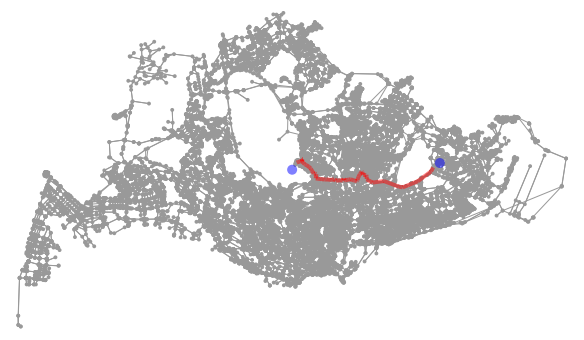

In [29]:
fig, ax = ox.plot_graph_route(G, middle_mile, origin_point=orig_xy, destination_point=target_xy)

## First mile

In [30]:
def print_route(route):
  i = 0
  n = len(route)

  for i in range(n):
    for nei,w in G_whole[route[i]].items():
      if i+1 != n:
        if nei == route[i+1]:
          print(w[0].get('highway'), w[0].get('length'))

In [31]:
orig_node, dist = ox.get_nearest_node(G_whole, orig_xy, method='haversine', return_dist = True)
first_mile = nx.shortest_path(G_whole, orig_node, sd_pair[0][0], weight='length', method='dijkstra')
first_mile_length = nx.shortest_path_length(G_whole, orig_node, sd_pair[0][0], weight='length', method='dijkstra')

print_route(first_mile)
print("Distance from X to A: ", dist) # in metres
print("Distance from A to B: ", first_mile_length) # in metres

residential 102.051
residential 7.747
residential 32.174
residential 124.57300000000001
residential 56.33
Distance from X to A:  482.23028553412615
Distance from A to B:  322.875


### Last Mile

In [32]:
target_node, dist = ox.get_nearest_node(G_whole, target_xy, method='haversine', return_dist= True)
last_mile = nx.shortest_path(G_whole, sd_pair[0][1], target_node, weight='length', method='dijkstra')
last_mile_length = nx.shortest_path_length(G_whole, sd_pair[0][1], target_node, weight='length', method='dijkstra')

print_route(last_mile)
print("Distance from C to D: ", last_mile_length)
print("Distance from D to Y: ", dist)

primary 561.0409999999999
primary 31.486
primary 10.98
primary 17.553
primary 11.666
primary 26.612
primary 256.842
primary 9.377
tertiary 13.573
primary 8.92
Distance from C to D:  948.0499999999998
Distance from D to Y:  0.0
